In [1]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from skopt import gp_minimize
from sklearn.ensemble import VotingClassifier

In [29]:
# Carregando banco de dados a partir de arquivos CSV
treino = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')

### Avaliando dados de treinamento

In [4]:
# Resumo do conteúdo do banco de dados de treinamento
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Soma das células vazias
treino.isnull().sum()

In [28]:
# Medidas estatisticas dos dados numéricos
treino['Fare'].where()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

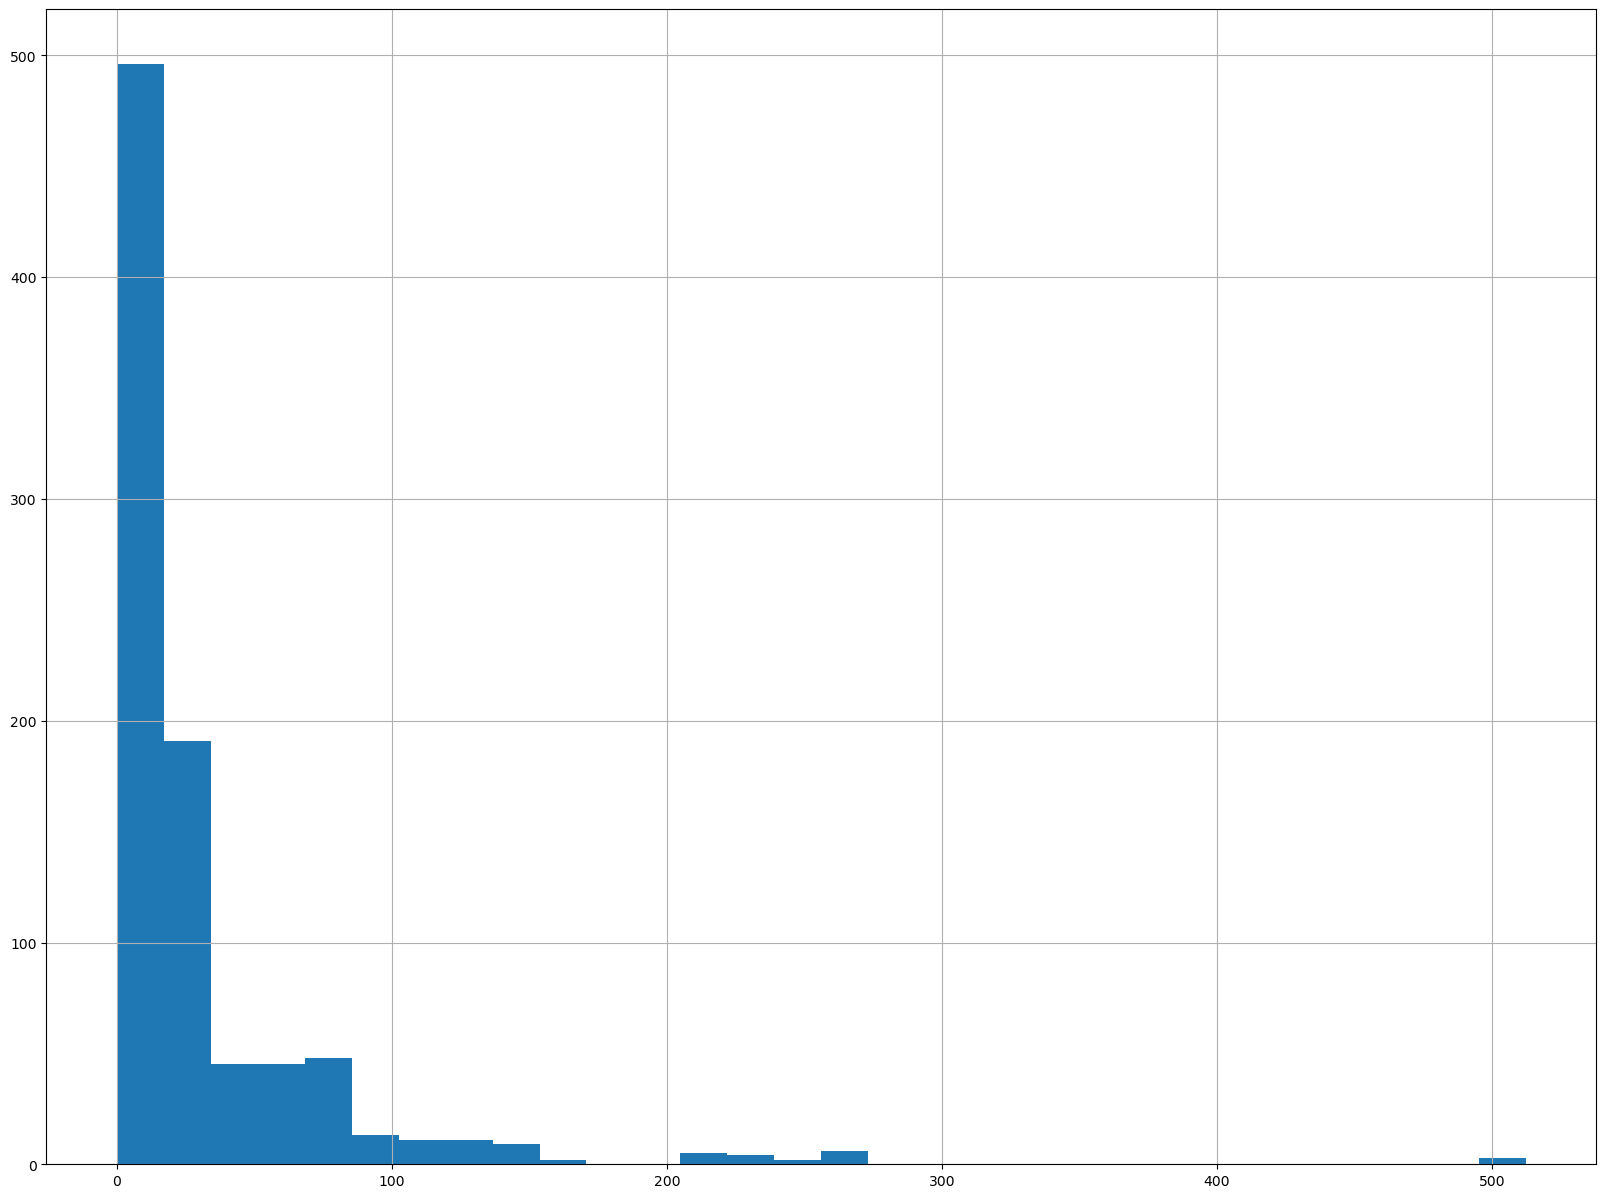

In [6]:
treino['Fare'].hist(bins=30, figsize=(20,15))
plt.show()

In [15]:
(teste['Fare']>500).value_counts()

False    417
True       1
Name: Fare, dtype: int64

In [3]:
# Mostrando primeiras 10 linhas
treino.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Avaliando dados de teste

In [ ]:
# Resumo do conteúdo do banco de dados de teste
teste.info()

In [ ]:
# Soma das células vazias
teste.isnull().sum()

### Ajustando os dados

In [ ]:
 # TEstes de features já realizados e sem melhoria no resutado
    
    # Ajuste da coluna Pclass para 0,1,2
    #subs = {1:0, 2:1, 3:2}
    #X['Pclass'] = X['Pclass'].replace(subs)
    
    # Preenchendo dados vazios em 'Embarked'
    #X['Embarked'] = X['Embarked'].fillna(method='ffill')
    
    # Ajuste da coluna Embarked para numérico
    #subs = {'S':0, 'C':1, 'Q':2}
    #X['Embarked'] = X['Embarked'].replace(subs)
    
     # Possui irmã/irmão/marido/mulher (0-não, 1-sim)
    #X['SibSp'] = np.where(X['SibSp']==0,0,1)

In [30]:
# Criando função para ajuste das features do banco de dados de teste e de treino

def features(X):
    # 1 - Ajuste da coluna Sex para numérico
    subs = {'female':1, 'male':0}
    X['Sex'] = X['Sex'].replace(subs)
        
    # 2 - Preenchendo dados vazios em 'Age'
    X['Age'] = X['Age'].fillna(method='ffill')
    
    # 3 - Preenchendo dados vazios em 'Fare'
    X['Fare'] = X['Fare'].fillna(method='ffill')
    X['Fare'] = X['Fare'].where(X['Fare']<500,32)
    
    # 4 - Possui pai/mae/filho/filha (0-não, 1-sim)
    X['Parch'] = X['Parch'].where(X['Parch']<1,1)
    
    # 5 - Crianças (0-menor 16 anos, 1-entre 16 e 55, 2-maior que 55 anos)
    X['idade'] = np.where(X['Age']<=16,0,1)
    X['idade'] = X['idade'].where(X['Age']<55,2)
    
    # 6 - Adultos (maior ou igual 16 anos): (0-sem filhos, 1-com filhos)
    X['filhos'] = np.where((X['Age']>16) & (X['Parch']!=0),1,0)
    
    # 7 - Crianças com ou sem pais (0-sem pais, 1-com pais)
    X['sempais'] = np.where((X['Age']<=16) & (X['Parch']==0),0,1)
    
    return X

In [31]:
# Aplicando ajuste nos dados de treino e teste

X_treino = features(treino)
X_teste = features(teste)
X_treino.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'idade', 'filhos',
       'sempais'],
      dtype='object')

In [32]:
# Selecionar as features

features = ['Pclass', 'Sex', 'Fare', 'idade', 'filhos', 'Parch', 'sempais']

X_treino = X_treino[features]
X_teste = X_teste[features]

Y_treino = treino['Survived']

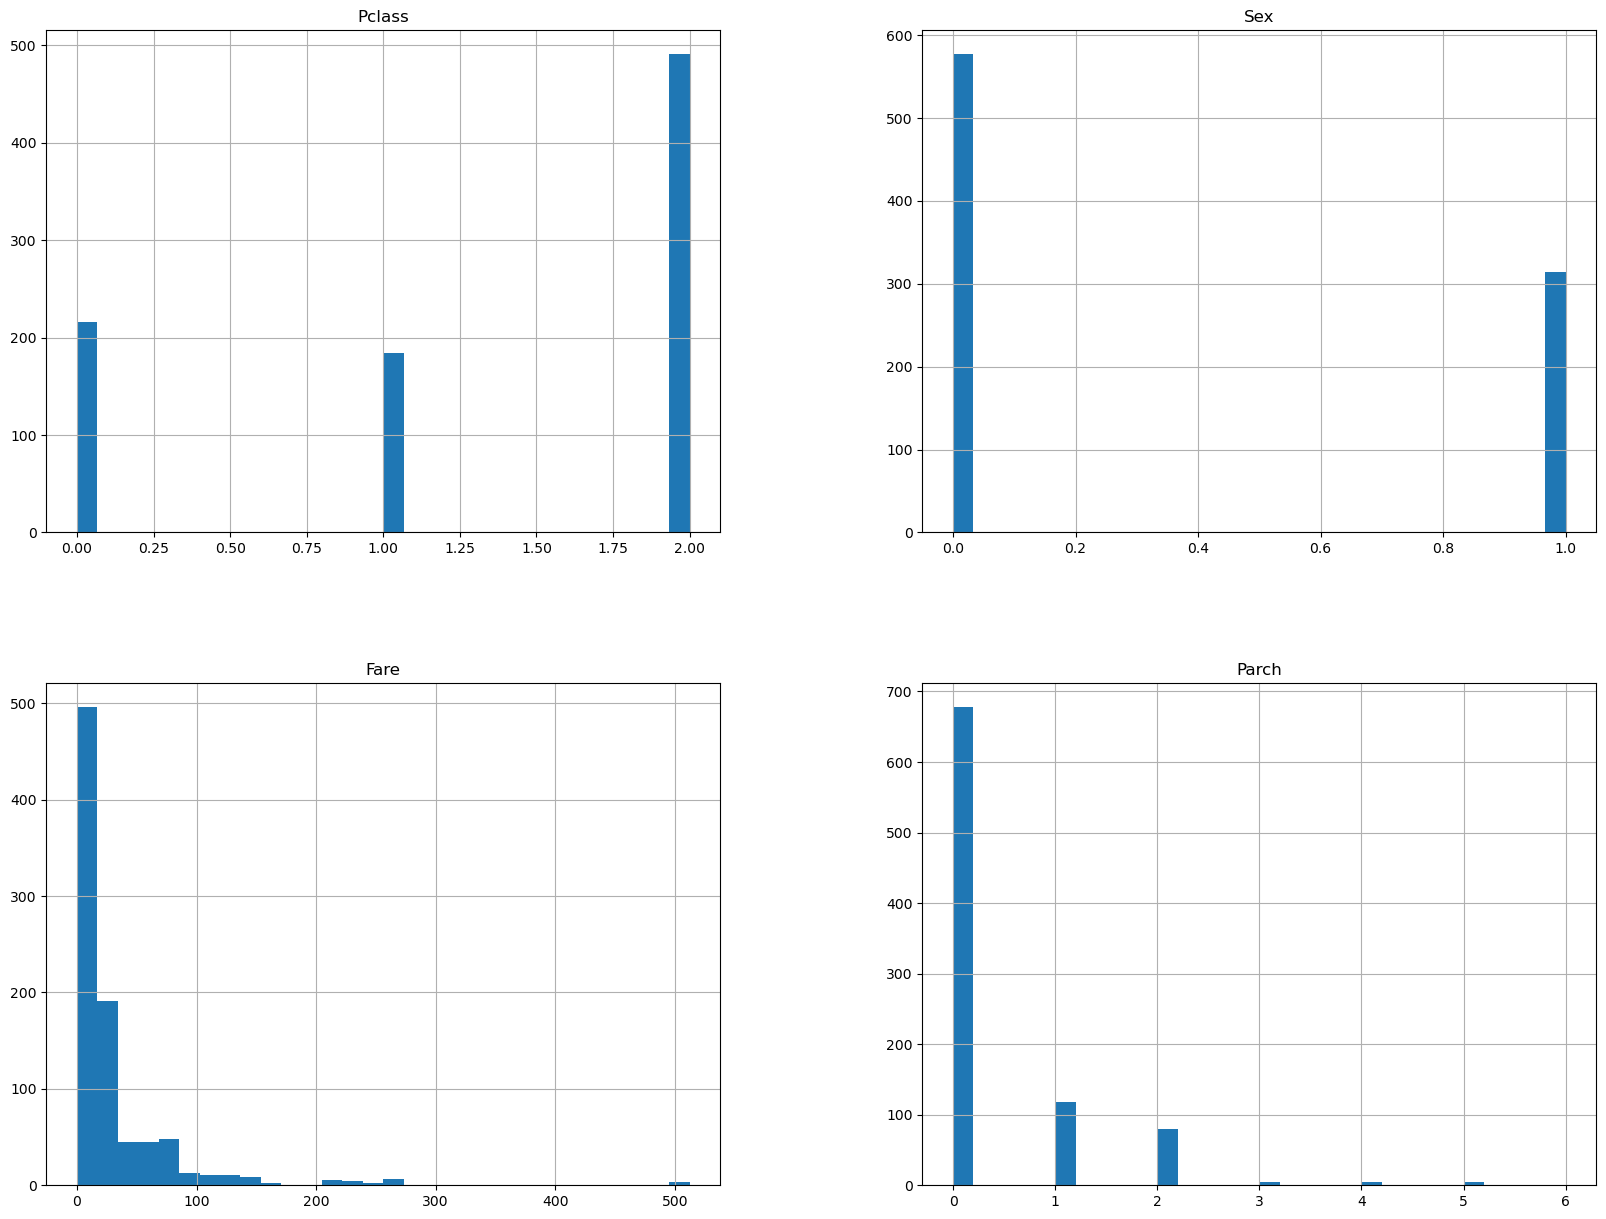

In [40]:
# Visualizando histograma dos dados de treino
X_treino.hist(bins=30, figsize=(20,15))
plt.show()

In [5]:
# Matriz de correlação entre as features de treino

X_treino.corr()

C:\Users\mbfio\AppData\Local\Temp\ipykernel_8964\2363481807.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_treino.corr()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,idade,filhos,sempais
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.026653,-0.053397,0.005167,0.012658,-0.027722,0.002207,0.021483,0.004871
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.065571,0.115867,0.147408,0.257307,0.113083,-0.105014,0.086618,-0.036552
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.291157,-0.076009,-0.027526,-0.549500,0.037256,-0.188667,-0.108665,-0.066544
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.058415,0.203203,0.247523,0.182333,0.123271,-0.082663,0.228036,-0.000876
Age,0.026653,-0.065571,-0.291157,-0.058415,1.000000,-0.135593,-0.246332,0.083417,0.033226,0.778310,0.113640,0.318141
SibSp,-0.053397,0.115867,-0.076009,0.203203,-0.135593,1.000000,0.420233,0.192190,-0.031095,-0.219967,0.265163,0.045337
Parch,0.005167,0.147408,-0.027526,0.247523,-0.246332,0.420233,1.000000,0.237717,-0.068874,-0.324432,0.744031,0.133746
Fare,0.012658,0.257307,-0.549500,0.182333,0.083417,0.192190,0.237717,1.000000,0.066980,0.022813,0.263264,0.042150
Embarked,-0.027722,0.113083,0.037256,0.123271,0.033226,-0.031095,-0.068874,0.066980,1.000000,0.009784,-0.035408,-0.120746
idade,0.002207,-0.105014,-0.188667,-0.082663,0.778310,-0.219967,-0.324432,0.022813,0.009784,1.000000,0.140140,0.493878


In [33]:
# Padronização das variáveis.
# Média 0 e desvio padrão 1

scaler = StandardScaler()
"""
X_treino_sc = scaler.fit_transform(X_treino)
X_teste_sc = scaler.fit_transform(X_teste)
"""

X_treino_sc = X_treino
X_teste_sc = X_teste

X_treino_sc[['Fare']] = scaler.fit_transform(X_treino[['Fare']])
X_teste_sc[['Fare']] = scaler.fit_transform(X_teste[['Fare']])

C:\Users\mbfio\AppData\Local\Temp\ipykernel_1396\4271323875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_treino_sc[['Fare']] = scaler.fit_transform(X_treino[['Fare']])
C:\Users\mbfio\AppData\Local\Temp\ipykernel_1396\4271323875.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_teste_sc[['Fare']] = scaler.fit_transform(X_teste[['Fare']])


In [34]:
X_treino_sc.describe()

,Pclass,Sex,Fare,idade,filhos,Parch,sempais
count,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,3.987333e-17,0.912458,0.148148,0.239057,0.946128
std,0.836071,0.477990,1.000562e+00,0.441107,0.355446,0.426747,0.225892
min,1.000000,0.000000,-7.444991e-01,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,-5.519566e-01,1.000000,0.000000,0.000000,1.000000
50%,3.000000,0.000000,-3.926777e-01,1.000000,0.000000,0.000000,1.000000
75%,3.000000,1.000000,1.005411e-02,1.000000,0.000000,0.000000,1.000000
max,3.000000,1.000000,5.657033e+00,2.000000,1.000000,1.000000,1.000000


### Treinando os modelos

In [7]:
# Modelo Logistic Regression

modelo_lr = LogisticRegression(random_state= 0)

score = cross_val_score(modelo_lr, X_treino_sc, Y_treino, cv = 10)

print(np.mean(score))


0.7890262172284643


In [8]:
# Modelo Naive Bayes

modelo_nb = GaussianNB()

score = cross_val_score(modelo_nb, X_treino_sc, Y_treino, cv = 10)

print(np.mean(score))

0.7531086142322099


In [9]:
# Modelo KNN para classificação

modelo_knn = KNeighborsClassifier(n_neighbors=5, p=2)

score = cross_val_score(modelo_knn, X_treino_sc, Y_treino, cv = 10)

print(np.mean(score))

0.8328464419475654


In [10]:
# Modelo SVM para classificação

modelo_svc = SVC(C = 3, kernel = 'rbf', degree = 2, gamma = 0.1)

score = cross_val_score(modelo_svc, X_treino_sc, Y_treino, cv = 10)

print(np.mean(score))

0.8193258426966292


In [11]:
# Modelo Decicion Tree

modelo_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 2, min_samples_leaf = 1, random_state = 0)

score = cross_val_score(modelo_dt, X_treino_sc, Y_treino, cv = 10)

print(np.mean(score))

0.8069538077403247


In [12]:
# Modelo Random Forest

modelo_rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 5, 
                                   min_samples_split = 2, min_samples_leaf = 1, random_state = 0)

score = cross_val_score(modelo_rf, X_treino_sc, Y_treino, cv = 10)

print(np.mean(score))

0.8193133583021222


### Otimização dos hiperparâmetros

In [35]:
# Grupo de Parâmetros para otimização do modelo Random Forest

parametros = [('entropy', 'gini', 'log_loss'),
             (100, 1000),
             (3,30),
             (2,12),
             (1,10)]

# Definindo a função de treino do modelo

def treinar_modelo_rf(parametros):
    
    modelo_rf = RandomForestClassifier(criterion = parametros[0], 
                                       n_estimators = parametros[1], 
                                       max_depth = parametros[2], 
                                       min_samples_split = parametros[3], 
                                       min_samples_leaf = parametros[4], 
                                       random_state = 0)
    score = cross_val_score(modelo_rf, X_treino_sc, Y_treino, cv = 10)
    print(np.mean(score))
    
    return -np.mean(score)

# Rodando a otimização do modelo

otimos = gp_minimize(treinar_modelo_rf, parametros, random_state = 0, 
                     verbose = True, n_calls = 40, n_random_starts = 10)

print(otimos.x)

# Ajustando hiperparâmetros do modelo ótimo obtido
modelo_rf = RandomForestClassifier(criterion = otimos.x[0], 
                                   n_estimators = otimos.x[1], 
                                   max_depth = otimos.x[2], 
                                   min_samples_split = otimos.x[3], 
                                   min_samples_leaf = otimos.x[4], 
                                   random_state = 0)

Iteration No: 1 started. Evaluating function at random point.
0.827191011235955
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.8161
Function value obtained: -0.8272
Current minimum: -0.8272
Iteration No: 2 started. Evaluating function at random point.
0.8182397003745319
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.1020
Function value obtained: -0.8182
Current minimum: -0.8272
Iteration No: 3 started. Evaluating function at random point.
0.8395755305867665
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.9796
Function value obtained: -0.8396
Current minimum: -0.8396
Iteration No: 4 started. Evaluating function at random point.
0.8204494382022472
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.2377
Function value obtained: -0.8204
Current minimum: -0.8396
Iteration No: 5 started. Evaluating function at random point.
0.8271910112359551
Iteration No: 5 ended. Evaluation done at random point.
Time tak

0.8305992509363295
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.8586
Function value obtained: -0.8306
Current minimum: -0.8407
Iteration No: 39 started. Searching for the next optimal point.
0.8092259675405742
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 7.4389
Function value obtained: -0.8092
Current minimum: -0.8407
Iteration No: 40 started. Searching for the next optimal point.
0.8384519350811483
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 10.6079
Function value obtained: -0.8385
Current minimum: -0.8407
['entropy', 422, 23, 8, 4]


In [36]:
# Grupo de Parâmetros para otimização do modelo SVM

parametros = [('rbf', 'poly', 'sigmoid'),
             (0.5, 4),
             (0.01, 0.1)]

# Definindo função

def treinar_modelo_svc(parametros):
    
    modelo_svc = SVC(kernel = parametros[0], C = parametros[1],
                     gamma = parametros[2], degree=4)

    score = cross_val_score(modelo_svc, X_treino_sc, Y_treino, 
                            cv = 10)

    print(np.mean(score))
    
    return -np.mean(score)

# Rodando a otimização

otimos = gp_minimize(treinar_modelo_svc, parametros, random_state = 0, 
                     verbose = True, n_calls = 50, 
                     n_random_starts = 10)

print(otimos.x)

# Ajustando hiperparâmetros do modelo ótimo
modelo_svc = SVC(kernel = otimos.x[0], C = otimos.x[1], gamma = otimos.x[2])

Iteration No: 1 started. Evaluating function at random point.
0.8114731585518105
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2140
Function value obtained: -0.8115
Current minimum: -0.8115
Iteration No: 2 started. Evaluating function at random point.
0.7621098626716605
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1511
Function value obtained: -0.7621
Current minimum: -0.8115
Iteration No: 3 started. Evaluating function at random point.
0.7833707865168539
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1910
Function value obtained: -0.7834
Current minimum: -0.8115
Iteration No: 4 started. Evaluating function at random point.
0.7867665418227217
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1899
Function value obtained: -0.7868
Current minimum: -0.8115
Iteration No: 5 started. Evaluating function at random point.
0.786729088639201
Iteration No: 5 ended. Evaluation done at random point.
Time tak

C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.8125842696629213
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4061
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 14 started. Searching for the next optimal point.


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.8125842696629213
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4072
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 15 started. Searching for the next optimal point.
0.7777777777777778
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4616
Function value obtained: -0.7778
Current minimum: -0.8148
Iteration No: 16 started. Searching for the next optimal point.
0.7811235955056179
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4080
Function value obtained: -0.7811
Current minimum: -0.8148
Iteration No: 17 started. Searching for the next optimal point.
0.786729088639201
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4860
Function value obtained: -0.7867
Current minimum: -0.8148
Iteration No: 18 started. Searching for the next optimal point.
0.7351810237203495
Iteration No: 18 ended. Search finished for the next optimal point.
Ti

C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.8125842696629213
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5380
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 20 started. Searching for the next optimal point.
0.7812109862671661
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5950
Function value obtained: -0.7812
Current minimum: -0.8148
Iteration No: 21 started. Searching for the next optimal point.


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.8125842696629213
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.5420
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 22 started. Searching for the next optimal point.


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.8125842696629213
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5610
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 23 started. Searching for the next optimal point.
0.616167290886392
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4352
Function value obtained: -0.6162
Current minimum: -0.8148
Iteration No: 24 started. Searching for the next optimal point.
0.8024843945068664
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.6020
Function value obtained: -0.8025
Current minimum: -0.8148
Iteration No: 25 started. Searching for the next optimal point.
0.786729088639201
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5070
Function value obtained: -0.7867
Current minimum: -0.8148
Iteration No: 26 started. Searching for the next optimal point.
0.7250062421972535
Iteration No: 26 ended. Search finished for the next optimal point.
Tim

C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5011
Function value obtained: -0.7867
Current minimum: -0.8148
Iteration No: 31 started. Searching for the next optimal point.


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.786729088639201
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.5030
Function value obtained: -0.7867
Current minimum: -0.8148
Iteration No: 32 started. Searching for the next optimal point.


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.786729088639201
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.5290
Function value obtained: -0.7867
Current minimum: -0.8148
Iteration No: 33 started. Searching for the next optimal point.
0.78
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.5710
Function value obtained: -0.7800
Current minimum: -0.8148
Iteration No: 34 started. Searching for the next optimal point.
0.7587515605493133
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.6130
Function value obtained: -0.7588
Current minimum: -0.8148
Iteration No: 35 started. Searching for the next optimal point.
0.7980024968789013
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.6340
Function value obtained: -0.7980
Current minimum: -0.8148
Iteration No: 36 started. Searching for the next optimal point.
0.8137078651685392
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.87

C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.8125842696629213
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.6489
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 38 started. Searching for the next optimal point.
0.6879775280898875
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.7630
Function value obtained: -0.6880
Current minimum: -0.8148
Iteration No: 39 started. Searching for the next optimal point.
0.8137078651685392
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.7562
Function value obtained: -0.8137
Current minimum: -0.8148
Iteration No: 40 started. Searching for the next optimal point.
0.8137078651685392
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.6104
Function value obtained: -0.8137
Current minimum: -0.8148
Iteration No: 41 started. Searching for the next optimal point.
0.8125967540574284
Iteration No: 41 ended. Search finished for the next optimal point.
T

C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.8125842696629213
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.7656
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 47 started. Searching for the next optimal point.
0.786729088639201


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.7631
Function value obtained: -0.7867
Current minimum: -0.8148
Iteration No: 48 started. Searching for the next optimal point.
0.786729088639201


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.7269
Function value obtained: -0.7867
Current minimum: -0.8148
Iteration No: 49 started. Searching for the next optimal point.
0.8125842696629213


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.7570
Function value obtained: -0.8126
Current minimum: -0.8148
Iteration No: 50 started. Searching for the next optimal point.


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.786729088639201
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.6620
Function value obtained: -0.7867
Current minimum: -0.8148
['rbf', 3.021622163679909, 0.1]


In [37]:
# Grupo de Parâmetros para otimização do modelo Logistic Regression

parametros = [(0.01, 3.0)]

# Definindo função

def treinar_modelo_lr(parametros):
    
    modelo_lr = LogisticRegression(C=parametros[0], random_state=0)

    score = cross_val_score(modelo_lr, X_treino_sc, Y_treino, cv = 10)

    print(np.mean(score))
    
    return -np.mean(score)

# Rodando a otimização

otimos = gp_minimize(treinar_modelo_lr, parametros, verbose = True, 
                     n_calls = 50, n_random_starts = 10, random_state=0)

print(otimos.x)

# Ajustando hiperparâmetros do modelo ótimo
modelo_lr = LogisticRegression(C=otimos.x[0], random_state= 0)

Iteration No: 1 started. Evaluating function at random point.
0.7834082397003745
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0952
Function value obtained: -0.7834
Current minimum: -0.7834
Iteration No: 2 started. Evaluating function at random point.
0.7834082397003745
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0900
Function value obtained: -0.7834
Current minimum: -0.7834
Iteration No: 3 started. Evaluating function at random point.
0.7834082397003745
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0980
Function value obtained: -0.7834
Current minimum: -0.7834
Iteration No: 4 started. Evaluating function at random point.
0.7834082397003745
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0820
Function value obtained: -0.7834
Current minimum: -0.7834
Iteration No: 5 started. Evaluating function at random point.
0.7834082397003745
Iteration No: 5 ended. Evaluation done at random point.
Time ta

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.2541
Function value obtained: -0.7834
Current minimum: -0.7879
Iteration No: 39 started. Searching for the next optimal point.
0.7834082397003745
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.2901
Function value obtained: -0.7834
Current minimum: -0.7879
Iteration No: 40 started. Searching for the next optimal point.
0.7834082397003745
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.3020
Function value obtained: -0.7834
Current minimum: -0.7879
Iteration No: 41 started. Searching for the next optimal point.
0.7834082397003745
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.2860
Function value obtained: -0.7834
Current minimum: -0.7879
Iteration No: 42 started. Searching for the next optimal point.
0.7834082397003745
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.3224
F

In [38]:
# Grupo de Parâmetros para otimização do modelo KNN

parametros = [(1, 15),
             ('uniform', 'distance'),
             (1, 8)]

# Definindo função

def treinar_modelo_knn(parametros):
    
    modelo_knn = KNeighborsClassifier(n_neighbors=parametros[0], 
                                      weights=parametros[1], 
                                      p=parametros[2])

    score = cross_val_score(modelo_knn, X_treino_sc, Y_treino, 
                            cv = 10)

    print(np.mean(score))
    
    return -np.mean(score)

# Rodando a otimização

otimos = gp_minimize(treinar_modelo_knn, parametros, random_state = 0, 
                     verbose = True, n_calls = 50, n_random_starts = 10)

print(otimos.x)

# Ajustando hiperparâmetros do modelo ótimo
modelo_knn = KNeighborsClassifier(n_neighbors=otimos.x[0], 
                                  weights=otimos.x[1], p=otimos.x[2])

Iteration No: 1 started. Evaluating function at random point.
0.8148938826466916
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0830
Function value obtained: -0.8149
Current minimum: -0.8149
Iteration No: 2 started. Evaluating function at random point.
0.7946441947565543
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0711
Function value obtained: -0.7946
Current minimum: -0.8149
Iteration No: 3 started. Evaluating function at random point.
0.8204619225967539
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0539
Function value obtained: -0.8205
Current minimum: -0.8205
Iteration No: 4 started. Evaluating function at random point.
0.8238451935081148
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0651
Function value obtained: -0.8238
Current minimum: -0.8238
Iteration No: 5 started. Evaluating function at random point.
0.8283520599250936
Iteration No: 5 ended. Evaluation done at random point.
Time ta

C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3090
Function value obtained: -0.8250
Current minimum: -0.8284
Iteration No: 25 started. Searching for the next optimal point.
0.8182272159800249
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3040
Function value obtained: -0.8182
Current minimum: -0.8284
Iteration No: 26 started. Searching for the next optimal point.
0.8250062421972535


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3480
Function value obtained: -0.8250
Current minimum: -0.8284
Iteration No: 27 started. Searching for the next optimal point.
0.8182022471910111
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3612
Function value obtained: -0.8182
Current minimum: -0.8284
Iteration No: 28 started. Searching for the next optimal point.
0.8250062421972535


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.2910
Function value obtained: -0.8250
Current minimum: -0.8284
Iteration No: 29 started. Searching for the next optimal point.
0.8159675405742821
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3030
Function value obtained: -0.8160
Current minimum: -0.8284
Iteration No: 30 started. Searching for the next optimal point.
0.8204744069912608
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3443
Function value obtained: -0.8205
Current minimum: -0.8284
Iteration No: 31 started. Searching for the next optimal point.
0.8283520599250936
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.3652
Function value obtained: -0.8284
Current minimum: -0.8284
Iteration No: 32 started. Searching for the next optimal point.
0.8283520599250936
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.3906
F

C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.5000
Function value obtained: -0.8284
Current minimum: -0.8284
Iteration No: 42 started. Searching for the next optimal point.
0.8193258426966292
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.5120
Function value obtained: -0.8193
Current minimum: -0.8284
Iteration No: 43 started. Searching for the next optimal point.
0.814843945068664
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.4741
Function value obtained: -0.8148
Current minimum: -0.8284
Iteration No: 44 started. Searching for the next optimal point.
0.8193508114856428
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.4686
Function value obtained: -0.8194
Current minimum: -0.8284
Iteration No: 45 started. Searching for the next optimal point.
0.8283520599250936


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.5069
Function value obtained: -0.8284
Current minimum: -0.8284
Iteration No: 46 started. Searching for the next optimal point.
0.8283520599250936


C:\Users\mbfio\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.4961
Function value obtained: -0.8284
Current minimum: -0.8284
Iteration No: 47 started. Searching for the next optimal point.
0.8249687890137329
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.4689
Function value obtained: -0.8250
Current minimum: -0.8284
Iteration No: 48 started. Searching for the next optimal point.
0.8148564294631709
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.5470
Function value obtained: -0.8149
Current minimum: -0.8284
Iteration No: 49 started. Searching for the next optimal point.
0.8159675405742821
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.5520
Function value obtained: -0.8160
Current minimum: -0.8284
Iteration No: 50 started. Searching for the next optimal point.
0.8204619225967539
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.4991
F

### Utilizando de modelos conjugados

In [39]:
# Criando classificador por voto
modelo_voto = VotingClassifier([('SVC', modelo_svc), ('KNN',modelo_knn), 
                                ('RF', modelo_rf)])
# Realizando ajuste
modelo_voto.fit(X_treino_sc, Y_treino)

score = cross_val_score(modelo_voto, X_treino_sc, Y_treino, cv = 10)

print(np.mean(score))

0.8451810237203496


### Predição nos dados de teste

In [40]:
# Realizando a predição
Y_teste = modelo_voto.predict(X_teste_sc)

# Criando arquivo para submeter ao Kaggle
submission = pd.DataFrame(teste['PassengerId'])
submission['Survived'] = Y_teste
submission.to_csv('submission8.csv', index=False)
